In [1]:
# Cài đặt các thư viện cần thiết
!pip install tensorflow keras scikit-learn pillow


In [5]:
from google.colab import drive
drive.mount('/content/drive')

train_data_dir = '/content/drive/MyDrive/Data/Train'
validation_data_dir = '/content/drive/MyDrive/Data/Val'
test_data_dir = '/content/drive/MyDrive/Data/Test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Định nghĩa các tham số
img_width, img_height = 128, 128
batch_size = 32

# Tạo các generator cho tập huấn luyện, xác thực và kiểm tra
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # hoặc 'categorical' nếu bạn có nhiều hơn 2 lớp
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # hoặc 'categorical' nếu bạn có nhiều hơn 2 lớp
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # hoặc 'categorical' nếu bạn có nhiều hơn 2 lớp
    shuffle=False
)


Found 1645 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Kiểm tra GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Tải mô hình VGG16 đã được huấn luyện trước (không bao gồm các lớp Fully Connected ở đầu cuối)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Trích xuất đặc trưng từ mô hình VGG16
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))  # Kích thước output của VGG16 (4x4x512)
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

# Trích xuất đặc trưng cho tập huấn luyện, xác thực và kiểm tra
num_train_samples = len(train_generator.filenames)
num_validation_samples = len(validation_generator.filenames)
num_test_samples = len(test_generator.filenames)

train_features, train_labels = extract_features(train_generator, num_train_samples)
validation_features, validation_labels = extract_features(validation_generator, num_validation_samples)
test_features, test_labels = extract_features(test_generator, num_test_samples)

# Reshape lại đặc trưng để phù hợp với input của SVM
train_features = np.reshape(train_features, (num_train_samples, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (num_validation_samples, 4 * 4 * 512))
test_features = np.reshape(test_features, (num_test_samples, 4 * 4 * 512))

# Huấn luyện mô hình SVM
svm = SVC(kernel='linear')
svm.fit(train_features, train_labels)

# Đánh giá mô hình trên tập xác thực
validation_predictions = svm.predict(validation_features)
validation_accuracy = accuracy_score(validation_labels, validation_predictions)
print(f'Validation accuracy: {validation_accuracy * 100:.2f}%')

# Đánh giá mô hình trên tập kiểm tra
test_predictions = svm.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Num GPUs Available:  1
1/1 [==============================] - 1s 1s/step
Validation accuracy: 97.00%
Test accuracy: 92.50%


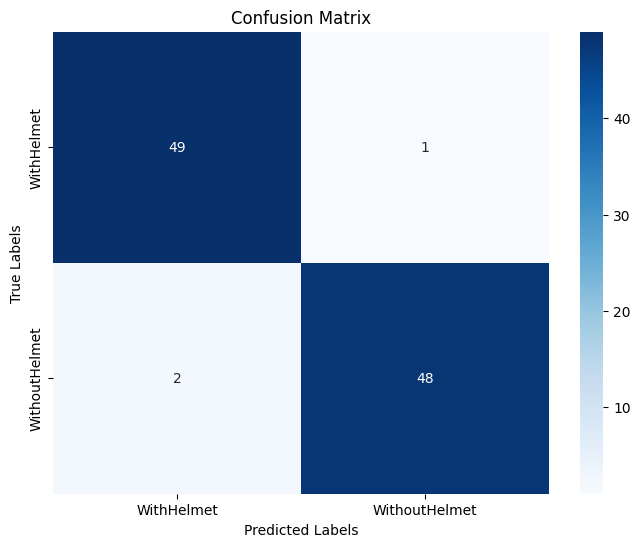

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(validation_labels, validation_predictions)

# Hiển thị confusion matrix sử dụng Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

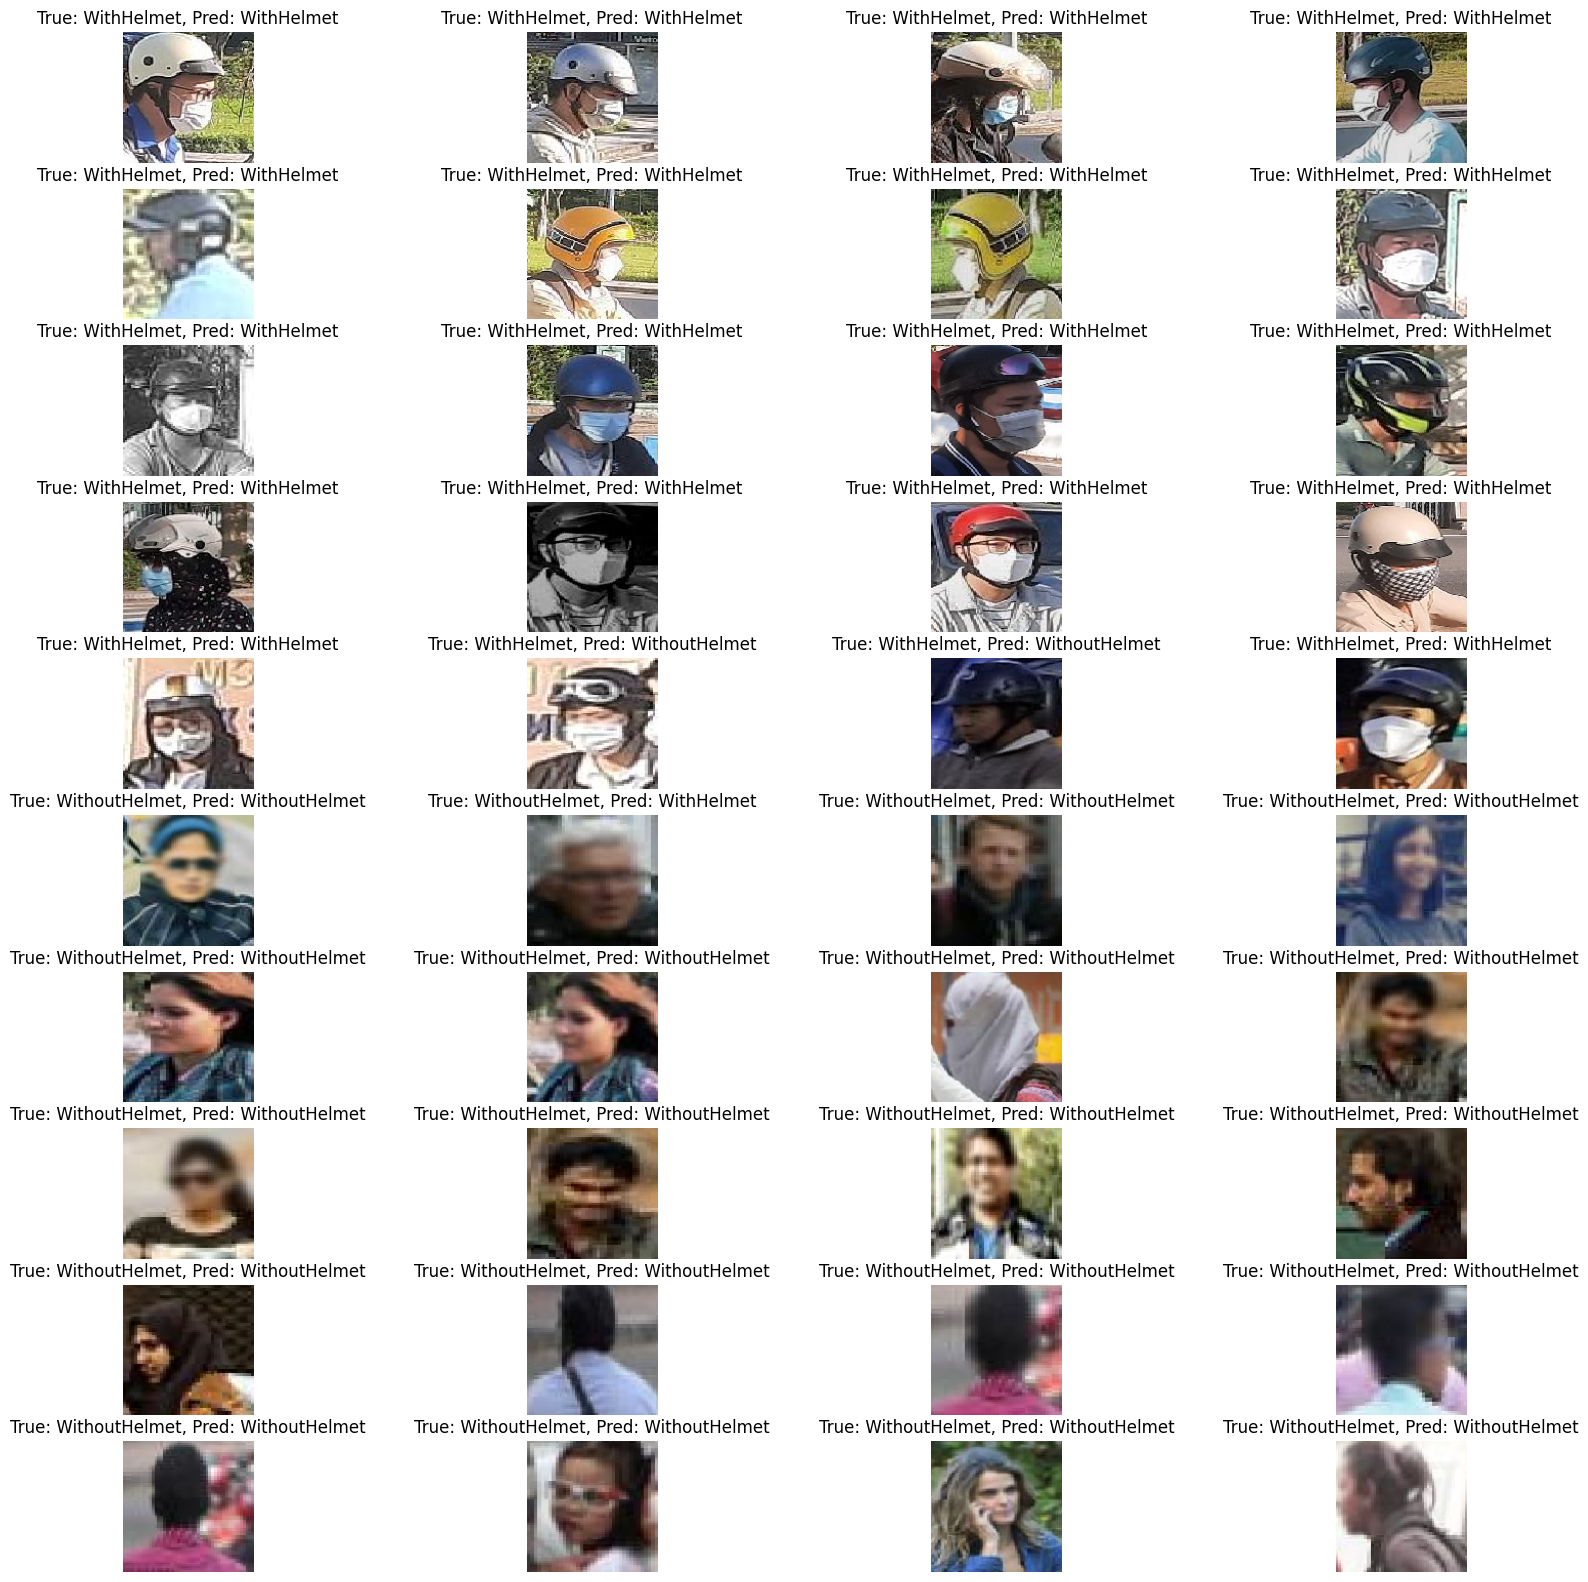

In [27]:
# Hiển thị ảnh trong tập test và dự đoán
def plot_images_with_predictions(generator, predictions, true_labels, batch_size=32):
    class_labels = list(generator.class_indices.keys())
    plt.figure(figsize=(20, 20))
    num_samples = min(len(predictions), len(true_labels))

    for i in range(num_samples):
        plt.subplot(10, 4, i + 1)
        # Tính toán batch index và image index trong batch
        batch_index = i // batch_size
        image_index = i % batch_size
        img = generator[batch_index][0][image_index]
        plt.imshow(img)
        plt.title(f"True: {class_labels[int(true_labels[i])]}, Pred: {class_labels[int(predictions[i])]}")
        plt.axis('off')
    plt.show()

plot_images_with_predictions(test_generator, test_predictions, test_labels)

1/1 [==============================] - 0s 36ms/step
Predicted class: WithHelmet


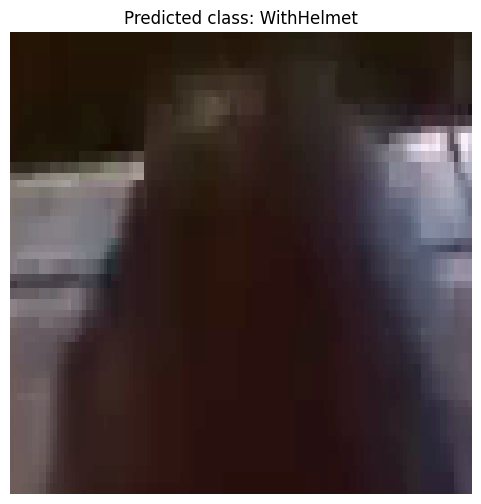

In [71]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Tiền xử lý và trích xuất đặc trưng cho ảnh mới
img = image.load_img("/content/test30.png", target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # Tiền xử lý ảnh mới
new_image_features = base_model.predict(img_array)  # Trích xuất đặc trưng từ VGG16

# Reshape và dự đoán lớp của ảnh mới
new_image_features = np.reshape(new_image_features, (1, 4 * 4 * 512))
prediction = svm.predict(new_image_features)

# Hiển thị kết quả dự đoán
class_labels = list(train_generator.class_indices.keys())
predicted_class = class_labels[int(prediction[0])]
print("Predicted class:", predicted_class)


# Hiển thị ảnh cùng với nhãn dự đoán
plt.figure(figsize=(6, 6))
plt.imshow(image.array_to_img(img_array[0]))
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')
plt.show()

In [66]:
from tensorflow.keras.applications.vgg16 import preprocess_input
def preprocess_person_image(img):
   img = cv2.resize(img, (img_width, img_height))
   img_array = image.img_to_array(img)
   img_array = np.expand_dims(img_array, axis=0)
   img_array = preprocess_input(img_array)  # Tiền xử lý ảnh mới
   new_image_features = base_model.predict(img_array)  # Trích xuất đặc trưng từ VGG16

   # Reshape và dự đoán lớp của ảnh mới
   new_image_features = np.reshape(new_image_features, (1, 4 * 4 * 512))
   prediction = svm.predict(new_image_features)

   # Hiển thị kết quả dự đoán
   class_labels = list(train_generator.class_indices.keys())
   predicted_class = class_labels[int(prediction[0])]
   return predicted_class

In [51]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.4/779.4 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [68]:
!pip install deep_sort_realtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 22.1 MB/s eta 0:00:00


In [69]:
import datetime
from ultralytics import YOLO
import cv2
from deep_sort_realtime.deepsort_tracker import DeepSort

CONFIDENCE_THRESHOLD = 0.4
GREEN = (0, 255, 0)
RED = (0,0,255)
WHITE = (255, 255, 255)

# initialize the video capture object
video_cap = cv2.VideoCapture("/content/demodoan.mp4")
# initialize the video writer object
# Get the video properties
frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video_cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = 'output.mp4'
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# load the pre-trained YOLOv8n model

model1 = YOLO("yolov8m.pt")
tracker = DeepSort(max_age=30,max_iou_distance = 0.8 ,n_init=3)
down_withhelmet ={}
tracked_ids = set()
counter = 0
while True:
    start = datetime.datetime.now()

    ret, frame = video_cap.read()

    if not ret:
        break

    # run the YOLO model on the frame
    detections = model1(frame,classes = 0, conf = 0.4,device = 0)[0]
    # initialize the list of bounding boxes and confidences
    results_withelmet = []
    ######################################
    # DETECTION
    ######################################

    # loop over the detections
    for data in detections.boxes.data.tolist():
        # extract the confidence (i.e., probability) associated with the prediction
        confidence = data[4]

        # filter out weak detections by ensuring the
        # confidence is greater than the minimum confidence
        if float(confidence) < CONFIDENCE_THRESHOLD:
            continue

        # if the confidence is greater than the minimum confidence,
        # get the bounding box and the class id
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        class_id = int(data[5])
        # add the bounding box (x, y, w, h), confidence and class id to the results list
        height = ymax - ymin
        cropped_height = height // 3  # Chia chiều cao thành 3 phần bằng nhau
        y2 = ymin + cropped_height
        crop_img  = frame[ymin:y2,xmin:xmax]
        id = preprocess_person_image(crop_img)
        if (id == "WithHelmet"):
              print("TRUE")
              results_withelmet.append([[xmin, ymin, xmax - xmin, ymax - ymin], confidence, class_id])
        tracks = tracker.update_tracks(results_withelmet, frame=frame)
    # loop over the tracks
    for track in tracks:
        # if the track is not confirmed, ignore it
        if not track.is_confirmed():
            continue
        if track.track_id not in tracked_ids:
            tracked_ids.add(track.track_id)
            counter += 1
        # get the track id and the bounding box
        track_id = track.track_id
        ltrb = track.to_ltrb()

        xmin, ymin, xmax, ymax = int(ltrb[0]), int(
            ltrb[1]), int(ltrb[2]), int(ltrb[3])

        # draw the bounding box and the track id
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), GREEN, 2)
        cv2.rectangle(frame, (xmin, ymin - 20), (xmin + 20, ymin), GREEN, -1)
        cv2.putText(frame, str(track_id),(xmin + 5, ymin - 8),cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)

    cv2.putText(frame,('With Helmet - ')+ str(counter),(60,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, RED, 1, cv2.LINE_AA)

    end = datetime.datetime.now()
    # show the time it took to process 1 frame
    print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} milliseconds")
    # calculate the frame per second and draw it on the frame
    fps = f"FPS: {1 / (end - start).total_seconds():.2f}"
    cv2.putText(frame,fps,(600,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, RED, 1, cv2.LINE_AA)
    # show the frame to our screen
    out.write(frame)
out.release()
video_cap.release()


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
TRUE
1/1 [==============================] - 0s 34ms/step
TRUE
Time to process 1 frame: 928 milliseconds

0: 384x640 5 persons, 29.7ms
Speed: 5.1ms preprocess, 29.7ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)
1/1 [==============================] - 0s 17ms/step
TRUE
1/1 [==============================] - 0s 26ms/step
TRUE
1/1 [==============================] - 0s 37ms/step
TRUE
1/1 [==============================] - 0s 62ms/step
TRUE
Time to process 1 frame: 875 milliseconds

0: 384x640 4 persons, 31.0ms
Speed: 5.4ms preprocess, 31.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
1/1 [==============================] - 0s 20ms/step
TRUE
1/1 [==============================] - 0s 33ms/step
TRUE
1/1 [==============================] - 0s 35ms/step
TRUE
1/1 [==============================] - 0s 31ms/step
Time to process 1 frame: 704 milliseconds

0: 384x640 5 persons, 25.4ms
Speed: 2.4ms preproc